## **GROUP MEMBER**
#### 1. Zhao Geping
#### 2. Lu TingJia (Tikko)
#### 3. Zhang Yonghan
#### 4. Wong Jia Shing (Emily)
#### 5. Nguyen Thanh Binh

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim

from collections import deque
import random
import warnings
warnings.filterwarnings('ignore')

try:
    import ta
    from stable_baselines3 import PPO, A2C, DQN, SAC
    from stable_baselines3.common.vec_env import DummyVecEnv
    from stable_baselines3.common.evaluation import evaluate_policy
except ImportError:
    print("Some RL or TA libraries not installed. Some features may not work.")

In [ ]:
# Download Data
TICKERS = ['AAPL', 'MSFT', 'GOOGL']
START_DATE = '2018-01-01'
today = datetime.datetime.today().strftime('%Y-%m-%d')
data = yf.download(TICKERS, start=START_DATE, end=today)['Close']
prices = data.dropna()
returns = np.log(prices / prices.shift(1)).dropna()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


In [ ]:
# Train/test split (80/20, by date)
split_idx = int(len(returns)*0.8)
train_returns = returns.iloc[:split_idx]
test_returns = returns.iloc[split_idx:]

print(f"Training: {train_returns.index[0]} to {train_returns.index[-1]}")
print(f"Testing:  {test_returns.index[0]} to {test_returns.index[-1]}")

Training: 2018-01-03 00:00:00 to 2023-11-22 00:00:00
Testing:  2023-11-24 00:00:00 to 2025-05-19 00:00:00


Train Baseline: {'CAGR': 0.255954890880735, 'Sharpe': 0.9487033248943342, 'Max Drawdown': -0.3566425225289731}
Test Baseline: {'CAGR': 0.12257302691306449, 'Sharpe': 0.6129095841144577, 'Max Drawdown': -0.26650884393983776}


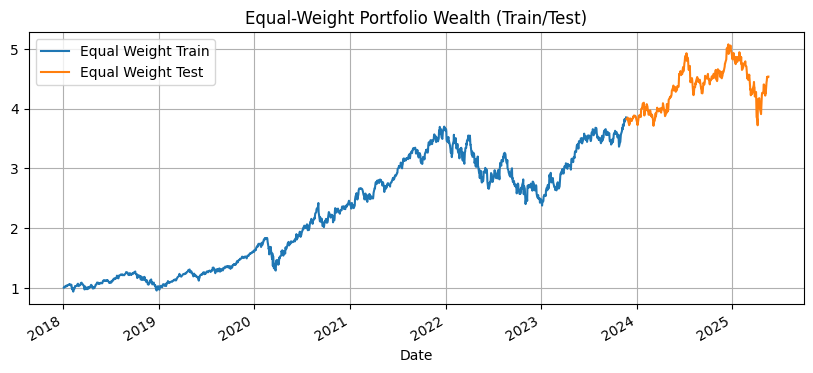

In [ ]:
# Baseline: Equal-Weight Portfolio (train/test)
def evaluate_performance(wealth_series):
    rets = wealth_series.pct_change().dropna()
    cagr = (wealth_series.iloc[-1]/wealth_series.iloc[0])**(252/len(wealth_series)) - 1
    sharpe = rets.mean() / (rets.std() + 1e-8) * np.sqrt(252)
    max_dd = ((wealth_series / wealth_series.cummax()) - 1).min()
    return {'CAGR': cagr, 'Sharpe': sharpe, 'Max Drawdown': max_dd}

equal_weight = np.array([1/len(TICKERS)]*len(TICKERS))

# Train period
train_eq_return = (train_returns @ equal_weight)
train_eq_wealth = np.exp(train_eq_return.cumsum())
train_eq_wealth.name = 'Equal Weight Train'

# Test period
test_eq_return = (test_returns @ equal_weight)
test_eq_wealth = train_eq_wealth.iloc[[-1]].values[0] * np.exp(test_eq_return.cumsum())
test_eq_wealth = pd.Series(test_eq_wealth, index=test_returns.index)
test_eq_wealth.name = 'Equal Weight Test'

print("Train Baseline:", evaluate_performance(train_eq_wealth))
print("Test Baseline:", evaluate_performance(test_eq_wealth))

plt.figure(figsize=(10,4))
train_eq_wealth.plot(label="Equal Weight Train")
test_eq_wealth.plot(label="Equal Weight Test")
plt.title("Equal-Weight Portfolio Wealth (Train/Test)")
plt.legend()
plt.grid(True);

Train DQN: {'CAGR': 0.18565942991410056, 'Sharpe': 0.696366462335024, 'Max Drawdown': -0.466111075876527}
Test DQN: {'CAGR': 0.16472383541790725, 'Sharpe': 0.6912414293476551, 'Max Drawdown': -0.24311115582975518}


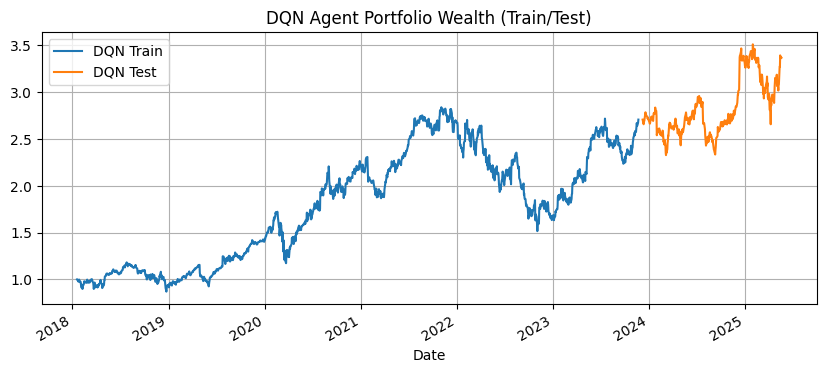

In [ ]:
# DQN Agent (discrete actions: one-hot allocation)

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    def forward(self, x):
        return self.net(x)

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.model = DQN(state_dim, action_dim)
        self.target = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99
        self.batch_size = 32
        self.update_target()

    def update_target(self):
        self.target.load_state_dict(self.model.state_dict())

    def act(self, state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, 2)
        with torch.no_grad():
            q = self.model(torch.FloatTensor(state))
            return torch.argmax(q).item()

    def store(self, s, a, r, s_, done):
        self.memory.append((s, a, r, s_, done))

    def train(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        s, a, r, s_, done = zip(*batch)
        s = torch.FloatTensor(np.array(s))
        a = torch.LongTensor(a)
        r = torch.FloatTensor(r)
        s_ = torch.FloatTensor(np.array(s_))
        done = torch.FloatTensor(done)
        q = self.model(s).gather(1, a.unsqueeze(1)).squeeze()
        max_q_ = self.target(s_).max(1)[0]
        target = r + self.gamma * max_q_ * (1 - done)
        loss = nn.MSELoss()(q, target.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# Training DQN on train set
window = 10
agent = DQNAgent(state_dim=3*window, action_dim=3)
eps = 1.0
state = train_returns.iloc[:window].values.flatten()
portfolio_value = 1.0
history = [portfolio_value]
for t in range(window, len(train_returns)-1):
    action_idx = agent.act(state, eps)
    action = np.zeros(3)
    action[action_idx] = 1
    next_ret = train_returns.iloc[t+1].values
    ret = np.dot(action, next_ret)
    reward = ret
    portfolio_value *= np.exp(ret)
    next_state = train_returns.iloc[t-window+1:t+1].values.flatten()
    agent.store(state, action_idx, reward, next_state, 0)
    agent.train()
    state = next_state
    history.append(portfolio_value)
    eps = max(eps * 0.995, 0.01)
    if t % 50 == 0:
        agent.update_target()
train_dqn_wealth = pd.Series(history, index=train_returns.index[window:window+len(history)])

# Test DQN (no learning!) on test set
test_state = test_returns.iloc[:window].values.flatten()
test_portfolio_value = train_dqn_wealth.iloc[[-1]].values[0]
test_history = [test_portfolio_value]
for t in range(window, len(test_returns)-1):
    action_idx = agent.act(test_state, 0.0)  # No exploration, exploit policy
    action = np.zeros(3)
    action[action_idx] = 1
    next_ret = test_returns.iloc[t+1].values
    ret = np.dot(action, next_ret)
    test_portfolio_value *= np.exp(ret)
    test_state = test_returns.iloc[t-window+1:t+1].values.flatten()
    test_history.append(test_portfolio_value)
test_dqn_wealth = pd.Series(test_history, index=test_returns.index[window:window+len(test_history)])

print("Train DQN:", evaluate_performance(train_dqn_wealth))
print("Test DQN:", evaluate_performance(test_dqn_wealth))

plt.figure(figsize=(10,4))
train_dqn_wealth.plot(label="DQN Train")
test_dqn_wealth.plot(label="DQN Test")
plt.title("DQN Agent Portfolio Wealth (Train/Test)")
plt.legend()
plt.grid(True);

Episode 1, Sharpe Reward: 0.0370
Episode 2, Sharpe Reward: 0.0324
Episode 3, Sharpe Reward: 0.0358
Episode 4, Sharpe Reward: 0.0365
Episode 5, Sharpe Reward: 0.0508
Episode 6, Sharpe Reward: 0.0512
Episode 7, Sharpe Reward: 0.0513
Episode 8, Sharpe Reward: 0.0513
Episode 9, Sharpe Reward: 0.0513
Episode 10, Sharpe Reward: 0.0513
Episode 11, Sharpe Reward: 0.0513
Episode 12, Sharpe Reward: 0.0513
Episode 13, Sharpe Reward: 0.0513
Episode 14, Sharpe Reward: 0.0513
Episode 15, Sharpe Reward: 0.0513
Episode 16, Sharpe Reward: 0.0513
Episode 17, Sharpe Reward: 0.0513
Episode 18, Sharpe Reward: 0.0513
Episode 19, Sharpe Reward: 0.0513
Episode 20, Sharpe Reward: 0.0513
Episode 21, Sharpe Reward: 0.0513
Episode 22, Sharpe Reward: 0.0513
Episode 23, Sharpe Reward: 0.0513
Episode 24, Sharpe Reward: 0.0513
Episode 25, Sharpe Reward: 0.0513
Episode 26, Sharpe Reward: 0.0513
Episode 27, Sharpe Reward: 0.0513
Episode 28, Sharpe Reward: 0.0513
Episode 29, Sharpe Reward: 0.0513
Episode 30, Sharpe Rewa

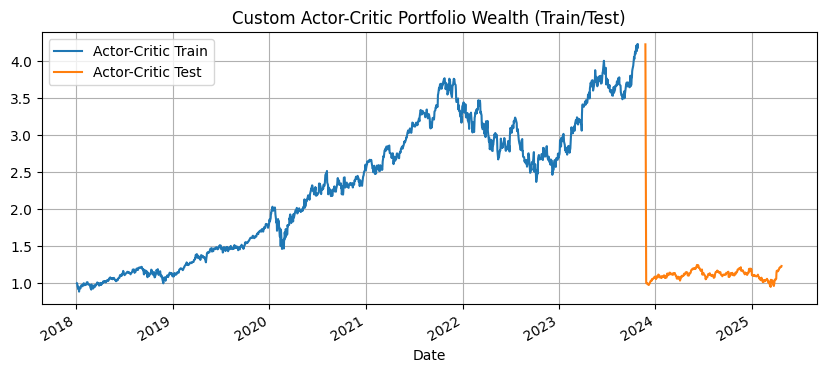

In [ ]:
# Custom Actor-Critic Portfolio Environment and Agent

class PortfolioEnv(gym.Env):
    def __init__(self, returns, window_size=20, commission=0.002, max_weight=0.5, max_turnover=0.2):
        super().__init__()
        self.data = returns
        self.window_size = window_size
        self.assets = returns.shape[1]
        self.commission = commission
        self.max_weight = max_weight
        self.max_turnover = max_turnover

        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(window_size, self.assets))
        self.action_space = spaces.Box(low=0, high=1, shape=(self.assets,))
        self.reset()

    def reset(self):
        self.step_idx = self.window_size
        self.weights = np.ones(self.assets) / self.assets
        self.portfolio_value = 1.0
        self.returns = []
        self.values = [self.portfolio_value]
        return self._get_obs()

    def _get_obs(self):
        return self.data.iloc[self.step_idx - self.window_size:self.step_idx].values

    def _apply_constraints(self, action):
        action = np.clip(action, 0, self.max_weight)
        action /= (np.sum(action) + 1e-8)
        turnover = np.sum(np.abs(action - self.weights))
        if turnover > self.max_turnover:
            action = self.weights + (action - self.weights) * (self.max_turnover / turnover)
        return action

    def step(self, action):
        action = self._apply_constraints(action)
        price_return = self.data.iloc[self.step_idx].values
        reward = np.dot(action, price_return) - self.commission * np.sum(np.abs(action - self.weights))

        self.weights = action
        self.portfolio_value *= np.exp(reward)
        self.returns.append(reward)
        self.values.append(self.portfolio_value)

        self.step_idx += 1
        done = self.step_idx >= len(self.data)
        return self._get_obs(), reward, done, {"value": self.portfolio_value}

# Custom Actor-Critic Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(state_dim, 128), nn.ReLU(),
            nn.Linear(128, action_dim), nn.Softmax(dim=-1)
        )
    def forward(self, x):
        return self.net(x)

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(state_dim + action_dim, 128), nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, s, a):
        s = s.reshape(s.size(0), -1)
        x = torch.cat([s, a], dim=1)
        return self.net(x)

# Train on train period
env = PortfolioEnv(train_returns)
actor = Actor(env.observation_space.shape[0] * env.assets, env.assets)
critic = Critic(env.observation_space.shape[0] * env.assets, env.assets)
actor_optim = optim.Adam(actor.parameters(), lr=1e-3)
critic_optim = optim.Adam(critic.parameters(), lr=1e-3)

episodes = 40
for ep in range(episodes):
    s = torch.tensor(env.reset(), dtype=torch.float32).unsqueeze(0)
    total_rewards = []
    done = False
    while not done:
        with torch.no_grad():
            a = actor(s).squeeze().numpy()
        s1, r, done, info = env.step(a)
        s1 = torch.tensor(s1, dtype=torch.float32).unsqueeze(0)
        a_tensor = torch.tensor(a, dtype=torch.float32).unsqueeze(0)

        # Critic update
        target = torch.tensor([[r]], dtype=torch.float32)
        q_val = critic(s, a_tensor)
        critic_loss = (q_val - target).pow(2).mean()
        critic_optim.zero_grad()
        critic_loss.backward()
        critic_optim.step()

        # Actor update
        a_pred = actor(s)
        actor_loss = -critic(s, a_pred).mean()
        actor_optim.zero_grad()
        actor_loss.backward()
        actor_optim.step()

        s = s1
        total_rewards.append(r)

    print(f"Episode {ep+1}, Sharpe Reward: {np.mean(total_rewards)/ (np.std(total_rewards)+1e-6):.4f}")

train_ac_wealth = pd.Series(env.values, index=train_returns.index[:len(env.values)])

# Test on test period (no learning)
test_env = PortfolioEnv(test_returns)
test_actor = actor  # Use trained policy
test_env.reset()
test_values = [train_ac_wealth.iloc[[-1]].values[0]]
s = torch.tensor(test_env.reset(), dtype=torch.float32).unsqueeze(0)
done = False
while not done:
    with torch.no_grad():
        a = test_actor(s).squeeze().numpy()
    s1, r, done, info = test_env.step(a)
    s = torch.tensor(s1, dtype=torch.float32).unsqueeze(0)
    test_values.append(info['value'])
test_ac_wealth = pd.Series(test_values, index=test_returns.index[:len(test_values)])

print("Train Actor-Critic:", evaluate_performance(train_ac_wealth))
print("Test Actor-Critic:", evaluate_performance(test_ac_wealth))

plt.figure(figsize=(10,4))
train_ac_wealth.plot(label="Actor-Critic Train")
test_ac_wealth.plot(label="Actor-Critic Test")
plt.title("Custom Actor-Critic Portfolio Wealth (Train/Test)")
plt.legend()
plt.grid(True);

- The agent performed well on training data, but failed badly on unseen test data. This is classic overfitting: it learned patterns in the training set that did not generalize.
- Poor generalization: The negative Sharpe and huge drawdown in test show the strategy did not adapt well to new market conditions.
- Possible causes:
1. Overfitting to noise in the training data
2. Insufficient regularization or too much model complexity
3. Market regime change (the test period was very different)
4. Not enough training data or episodes
5. RL agent not robust to out-of-sample data

Test SB3 PPO: {'CAGR': -0.04948932224952751, 'Sharpe': 0.01531196731778067, 'Max Drawdown': -0.28415841655361573}


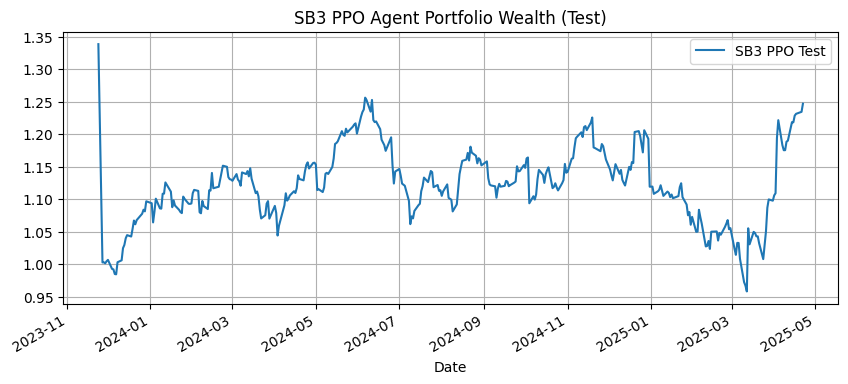

In [ ]:
# SB3 PPO

if 'PPO' in globals():
    # Quick env wrapper for SB3: same as PortfolioEnv, but with flat obs
    class SB3PortfolioEnv(gym.Env):
        def __init__(self, returns, window_size=20):
            super().__init__()
            self.data = returns
            self.window_size = window_size
            self.assets = returns.shape[1]
            self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(window_size*self.assets,))
            self.action_space = spaces.Box(low=0, high=1, shape=(self.assets,))
            self.reset()

        def reset(self):
            self.step_idx = self.window_size
            self.weights = np.ones(self.assets) / self.assets
            self.portfolio_value = 1.0
            self.values = [self.portfolio_value]
            return self._get_obs()

        def _get_obs(self):
            return self.data.iloc[self.step_idx - self.window_size:self.step_idx].values.flatten()

        def step(self, action):
            action = np.clip(action, 0, 1)
            action /= (np.sum(action) + 1e-8)
            price_return = self.data.iloc[self.step_idx].values
            reward = np.dot(action, price_return)  # No commission for simplicity
            self.weights = action
            self.portfolio_value *= np.exp(reward)
            self.values.append(self.portfolio_value)
            self.step_idx += 1
            done = self.step_idx >= len(self.data)
            return self._get_obs(), reward, done, {}

    # Train on train_returns
    train_env_sb3 = DummyVecEnv([lambda: SB3PortfolioEnv(train_returns)])
    model = PPO("MlpPolicy", train_env_sb3, verbose=0)
    model.learn(total_timesteps=1500)

    # Test on test_returns
    test_env_sb3 = SB3PortfolioEnv(test_returns)
    obs = test_env_sb3.reset()
    test_values = [train_env_sb3.envs[0].values[-1]]  # Start from end of train
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = test_env_sb3.step(action)
        test_values.append(test_env_sb3.portfolio_value)
    test_sb3_wealth = pd.Series(test_values, index=test_returns.index[:len(test_values)])

    print("Test SB3 PPO:", evaluate_performance(test_sb3_wealth))
    plt.figure(figsize=(10,4))
    test_sb3_wealth.plot(label="SB3 PPO Test")
    plt.title("SB3 PPO Agent Portfolio Wealth (Test)")
    plt.legend()
    plt.grid(True);

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1194 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------


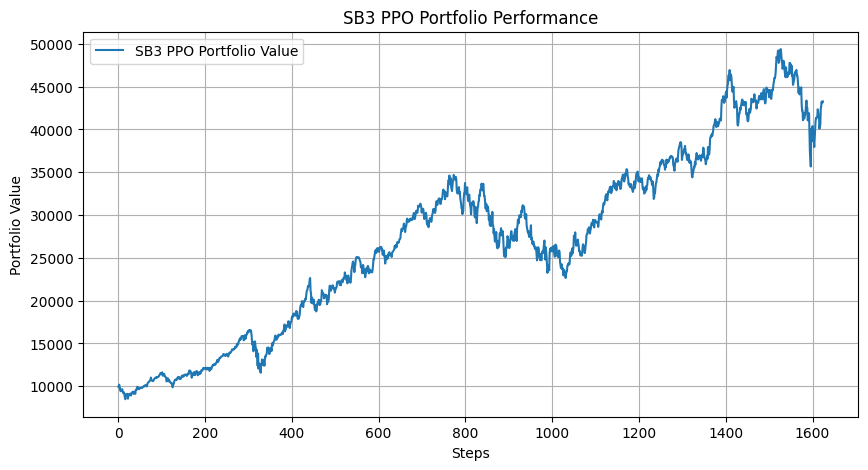

In [ ]:
# 6. Stable-Baselines3 Modular Pipeline (PPO example, Gymnasium API compatible)
# Only runs if SB3 and ta are available

if 'DummyVecEnv' in globals():
    class PortfolioOptimizationEnv(gym.Env):
        def __init__(self, df, stocks, initial_amount=10000, window_size=30, transaction_cost_pct=0.001, seed=None):
            super().__init__()
            self.df = df
            self.stocks = stocks
            self.num_stocks = len(stocks)
            self.initial_amount = initial_amount
            self.current_amount = initial_amount
            self.window_size = window_size
            self.transaction_cost_pct = transaction_cost_pct
            self.current_step = window_size
            self.action_space = gym.spaces.Box(low=0, high=1, shape=(len(stocks),), dtype=np.float32)
            num_features_per_stock = len([col for col in df.columns if stocks[0] in col])
            state_dim = window_size * num_features_per_stock * self.num_stocks + self.num_stocks
            self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(state_dim,), dtype=np.float32)
            self.portfolio_value = initial_amount
            self.portfolio_weights = np.zeros(self.num_stocks)
            self.portfolio_history = [initial_amount]
            self.benchmark_history = [initial_amount]
            self.dates = df.index.unique()
            self.current_date = None
            if seed is not None:
                np.random.seed(seed)
                self.action_space.seed(seed)

        def reset(self, *, seed=None, options=None):
            super().reset(seed=seed)
            self.current_step = self.window_size
            self.current_amount = self.initial_amount
            self.portfolio_value = self.initial_amount
            self.portfolio_weights = np.zeros(self.num_stocks)
            self.portfolio_history = [self.initial_amount]
            self.benchmark_history = [self.initial_amount]
            if self.current_step < len(self.df.index.unique()):
                self.current_date = self.dates[self.current_step]
            observation = self._get_observation()
            info = {}  # Gymnasium/SB3 expects (obs, info)
            return observation, info

        def step(self, action):
            action = action / (np.sum(action) + 1e-8)
            cost = self._calculate_transaction_cost(action)
            prev_portfolio_value = self.portfolio_value
            self.current_step += 1
            done = self.current_step >= len(self.dates) - 1
            terminated = done
            truncated = False
            if not done:
                self.current_date = self.dates[self.current_step]
                self.portfolio_value = self._update_portfolio_value(action)
                self.portfolio_value -= cost
                self.portfolio_history.append(self.portfolio_value)
                benchmark_action = np.ones(self.num_stocks) / self.num_stocks
                benchmark_value = self._update_portfolio_value(benchmark_action)
                self.benchmark_history.append(benchmark_value)
                reward = self._calculate_reward(prev_portfolio_value, cost)
                observation = self._get_observation()
                self.portfolio_weights = action
                info = {'portfolio_value': self.portfolio_value}
                return observation, reward, terminated, truncated, info
            observation = self._get_observation()
            reward = self._calculate_reward(prev_portfolio_value, cost)
            info = {'portfolio_value': self.portfolio_value}
            return observation, reward, terminated, truncated, info

        def _get_observation(self):
            start_idx = self.df.index.get_indexer([self.dates[self.current_step - self.window_size]])[0]
            end_idx = self.df.index.get_indexer([self.dates[self.current_step]])[0]
            window_data = self.df.iloc[start_idx:end_idx+1]
            obs_list = []
            for stock in self.stocks:
                stock_data = window_data[[col for col in window_data.columns if stock in col]]
                obs_list.append(stock_data.values.flatten())
            obs_list.append(self.portfolio_weights)
            observation = np.concatenate(obs_list)
            if observation.shape[0] > self.observation_space.shape[0]:
                observation = observation[:self.observation_space.shape[0]]
            elif observation.shape[0] < self.observation_space.shape[0]:
                padding = np.zeros(self.observation_space.shape[0] - observation.shape[0])
                observation = np.concatenate([observation, padding])
            return observation.astype(np.float32)

        def _calculate_transaction_cost(self, new_weights):
            weight_diff = np.abs(new_weights - self.portfolio_weights)
            cost = np.sum(weight_diff) * self.transaction_cost_pct * self.portfolio_value
            return cost

        def _update_portfolio_value(self, weights):
            current_day_idx = self.df.index.get_indexer([self.dates[self.current_step]])[0]
            prev_day_idx = self.df.index.get_indexer([self.dates[self.current_step - 1]])[0]
            current_prices = []
            prev_prices = []
            for stock in self.stocks:
                close_col = [col for col in self.df.columns if stock in col and 'close' in col.lower()][0]
                current_prices.append(self.df.iloc[current_day_idx][close_col])
                prev_prices.append(self.df.iloc[prev_day_idx][close_col])
            current_prices = np.array(current_prices)
            prev_prices = np.array(prev_prices)
            price_change_ratio = current_prices / prev_prices
            weighted_return = np.sum(weights * price_change_ratio)
            new_value = self.portfolio_value * weighted_return
            return new_value

        def _calculate_reward(self, prev_value, cost):
            if prev_value <= 1e-8:
                prev_value = 1e-8
            if self.portfolio_value <= 1e-8:
                self.portfolio_value = 1e-8
            portfolio_return = (self.portfolio_value - prev_value) / prev_value
            reward = portfolio_return - (cost / self.portfolio_value)
            if len(self.portfolio_history) > 20:
                portfolio_values = np.array(self.portfolio_history[-21:])
                if np.any(portfolio_values <= 1e-8):
                    portfolio_values = np.clip(portfolio_values, 1e-8, None)
                returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]
                if not np.isnan(returns).any() and np.std(returns) > 0:
                    sharpe = np.mean(returns) / (np.std(returns) + 1e-6) * np.sqrt(252)
                    reward += 0.1 * sharpe
            if np.isnan(reward):
                reward = 0.0
            return reward

    # Example pipeline (PPO)
    # Data preparation
    df = prices.copy()
    for stock in TICKERS:
        df[f"{stock}_Close"] = prices[stock]
        # Add sample technicals
        df[f"{stock}_SMA_30"] = df[f"{stock}_Close"].rolling(30).mean()
        df[f"{stock}_SMA_200"] = df[f"{stock}_Close"].rolling(200).mean()
    df.dropna(inplace=True)

    env = PortfolioOptimizationEnv(df, TICKERS, initial_amount=10000, window_size=30)
    vec_env = DummyVecEnv([lambda: env])

    model = PPO("MlpPolicy", vec_env, verbose=1)
    model.learn(total_timesteps=1000)
    obs = vec_env.reset()
    done = False
    values = []
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = vec_env.step(action)
        info = info[0] if isinstance(info, (list, tuple)) else info
        values.append(info['portfolio_value'])
        if done:
            break
    plt.figure(figsize=(10, 5))
    plt.plot(values, label='SB3 PPO Portfolio Value')
    plt.title('SB3 PPO Portfolio Performance')
    plt.xlabel('Steps')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid(True)

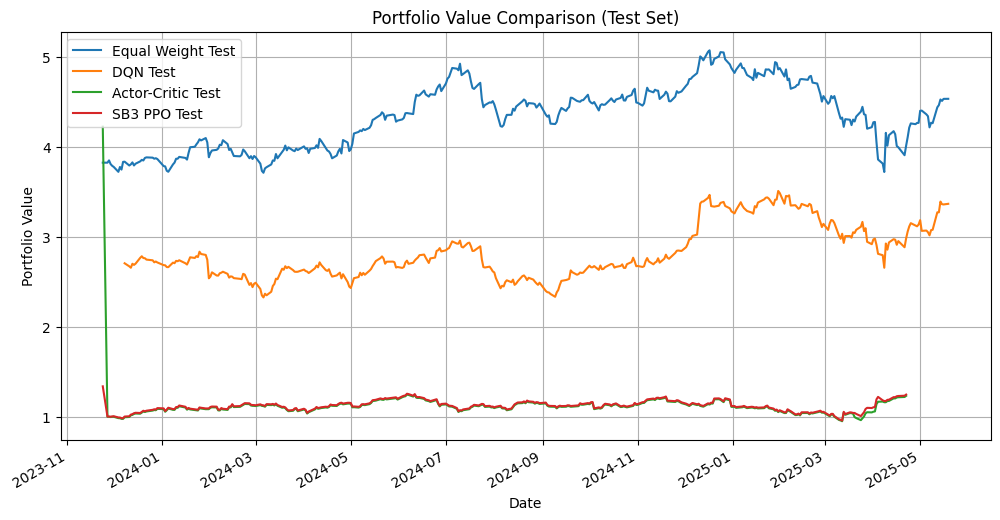

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Combine all wealth series into a single DataFrame for perfect alignment
wealth_dfs = [
    test_eq_wealth.rename("Equal Weight Test"),
    test_dqn_wealth.rename("DQN Test"),
    test_ac_wealth.rename("Actor-Critic Test")
]
if "test_sb3_wealth" in locals():
    wealth_dfs.append(test_sb3_wealth.rename("SB3 PPO Test"))

comparison_df = pd.concat(wealth_dfs, axis=1)

plt.figure(figsize=(12, 6))
comparison_df.plot(ax=plt.gca())
plt.title("Portfolio Value Comparison (Test Set)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)

In [ ]:
comparison_df

,Equal Weight Test,DQN Test,Actor-Critic Test,SB3 PPO Test
Date,,,,
2023-11-24,3.823648,NaN,4.223929,1.338570
2023-11-27,3.823804,NaN,1.001380,1.002784
2023-11-28,3.849033,NaN,1.000479,1.002998
2023-11-29,3.808481,NaN,0.997683,1.001419
2023-11-30,3.789265,NaN,0.999812,1.004658
...,...,...,...,...
2025-05-13,4.463347,3.271612,NaN,NaN
2025-05-14,4.525605,3.391378,NaN,NaN
2025-05-15,4.509849,3.362462,NaN,NaN
